In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#file     = uproot.open('./20230523/laser000010.bin.root')
#file     = uproot.open('./20230525/dark_tr100000013.bin.root')
#file     = uproot.open('/Users/ishiwata/grams/data/20230529/laser_tr60_bl129_1000ns_delay240ns_CFD000025.bin.root')
#file     = uproot.open('./20230530/laser_tr60_bl129_1000ns_delay240ns_CFD000027.bin.root')
#file     = uproot.open('./20230530/laser_tr60_bl129_1000ns_delay240ns_CFD_qdcfilter200ns000028.bin.root')
#file     = uproot.open('./20230530/laser_tr60_bl129_1000ns_delay240ns_CFD_qdcfilter100ns000029.bin.root')
file     = uproot.open('/Users/ishiwata/grams/data/20230616/liquidN_tr150_bl129000085.bin.root')



header   = file['header']
tree     = file['tree']

QDC      = tree.arrays(['qdc'], library='numpy')['qdc']
waveform = tree.arrays(['waveform'], library='numpy')['waveform']
timebin_width = header.arrays(['timebin_width'], library='numpy')['timebin_width'] #ns
wave_num = tree.arrays(['wave_num'], library='numpy')['wave_num'][0]
time_array    = np.arange(wave_num) * timebin_width #* ns2us

In [3]:
#異常なdataを排除
numlist=[]
bad_numlist=[]
n=0
for i in range(23000):
    p2p=np.max(waveform[i])-np.min(waveform[i])
    if p2p < 3000:
        numlist.append(n)
    else:
        bad_numlist.append(n)
    n=n+1
print(len(numlist))
print(len(bad_numlist))

23000
0


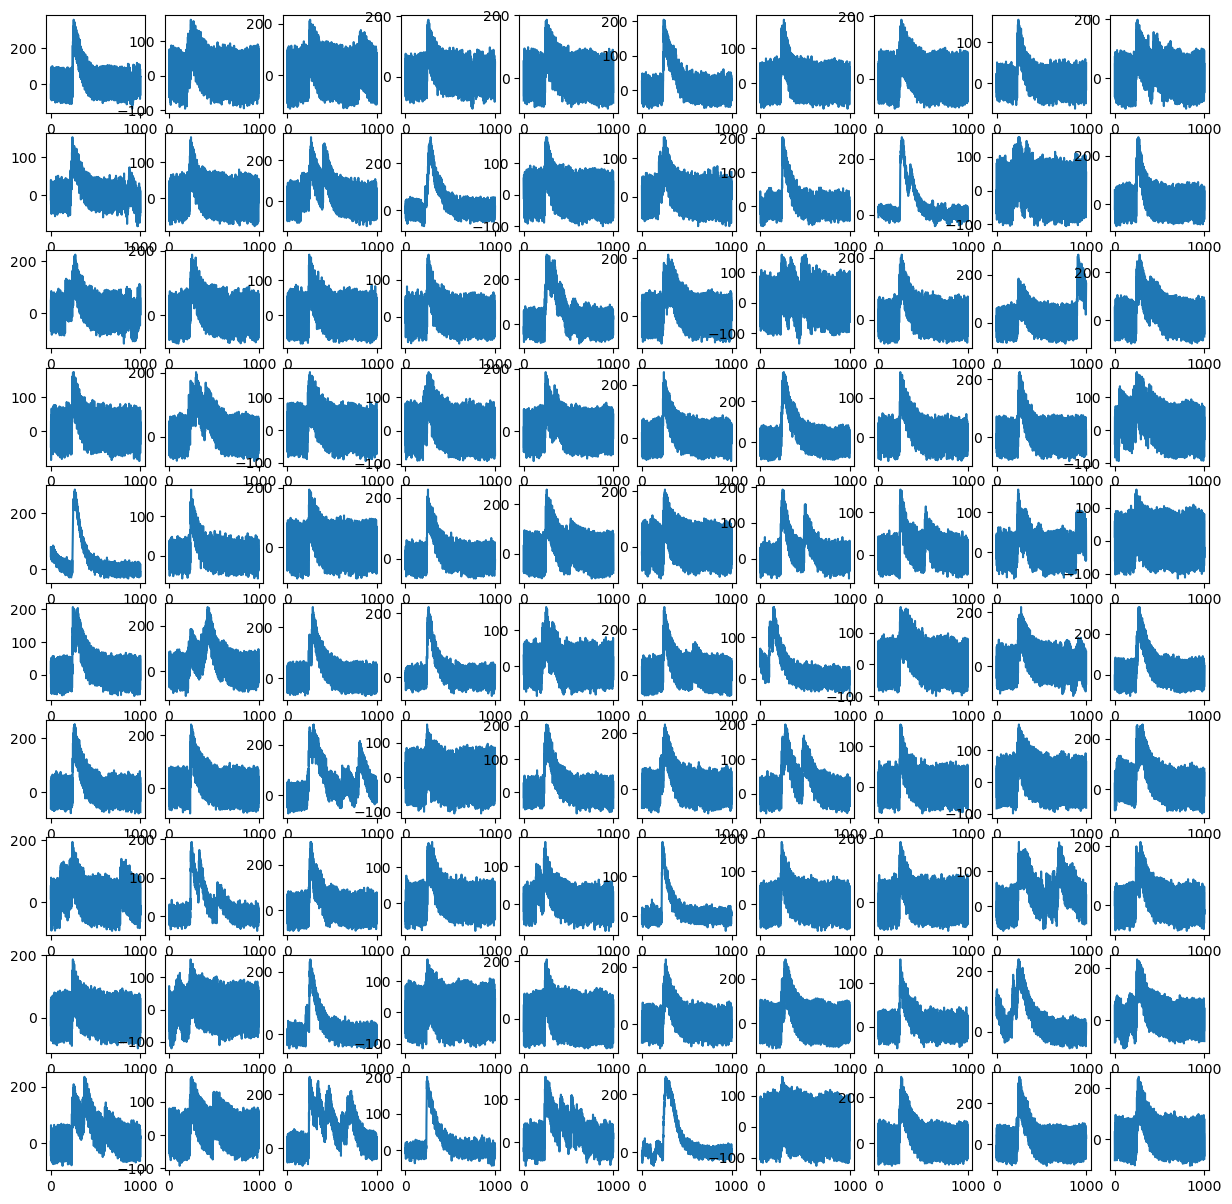

In [71]:
plt.figure(figsize=(15,15))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.plot(time_array,waveform[i+22900])


In [78]:
fft_wave=np.zeros((len(waveform),1000))
for i in range(len(waveform)):
    offset=abs(np.min(waveform[i]))
    X=waveform[i]+offset
    N =len(X)      #データ長
    fs=1e+9          #サンプリング周波数
    dt =1/fs       # サンプリング間隔
    t = np.arange(0.0, N*dt, dt) #時間軸
    freq = np.linspace(0, fs,N) #周波数軸
    fn=1/dt/2     #ナイキスト周波数
    F=np.fft.fft(X)/(N/2)
    F[(freq>fn)]=0 #ナイキスト周波数以降をカット
    X_0=np.abs(F)
    threshold=np.amax(X_0)*0.03
    peak_index=np.where(X_0 > threshold) #threshold以上のpeak_indexを抽出
    peak_freq=[]
    for n in peak_index[0]:
        if freq[n] > 1e7:
            peak_freq.append(freq[n])

    for hz in peak_freq:
        F[(freq==hz)]=0
    X_1=np.abs(F) #trendを除去した波形(横軸周波数)
    X_2=np.real(np.fft.ifft(F))*N #trendを除去した波形(横軸時間[ns]) waveform

    fft_wave[i]=X_2
    

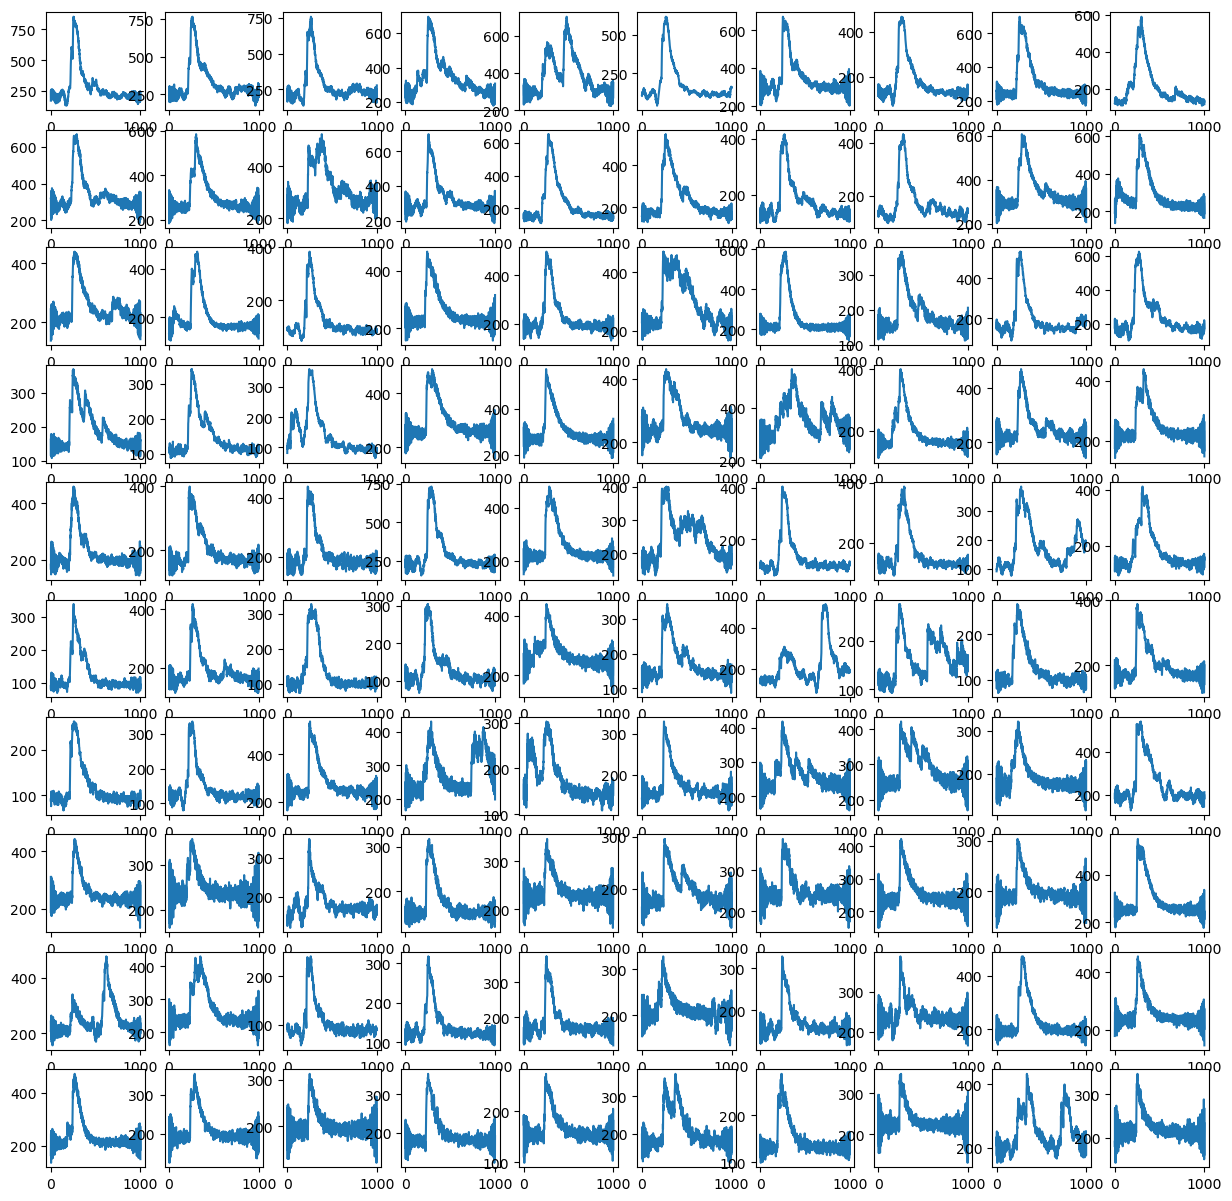

In [163]:
plt.figure(figsize=(15,15))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.plot(time_array,fft_wave[i])

In [92]:
#移動平均filterをかける
filter_wave=np.zeros((len(waveform),1000))
v = np.ones(10)/10.0
for i in range(len(waveform)):
    filter_wave[i]=np.convolve(fft_wave[i],v,mode="same")

from scipy.ndimage import gaussian_filter1d as gf
gfil_wave=np.zeros((len(waveform),1000))
for i in range(len(waveform)):
    gfil_wave[i]=gf(fft_wave[i],sigma=3,mode="wrap",)



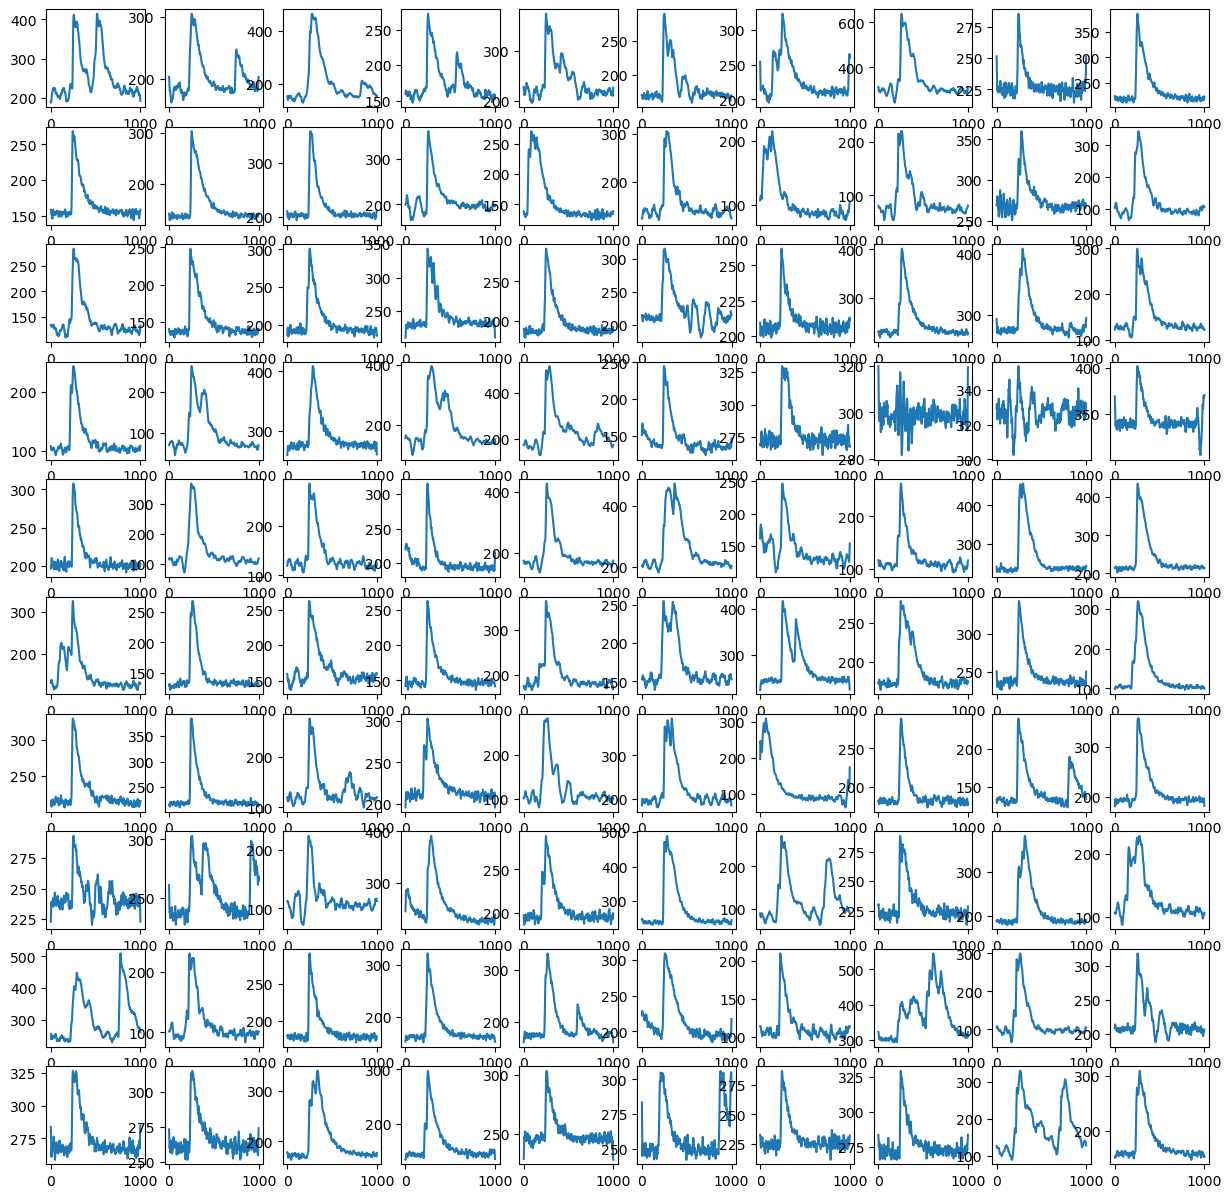

In [192]:
plt.figure(figsize=(15,15))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.plot(time_array,gfil_wave[i+900])
    #plt.title(f"{i+600}")

In [160]:
#gainの算出
qdc=np.zeros(len(waveform))

for i in range(len(waveform)):
    peak_index=np.argmax(waveform[i])
    qdc[i]=np.sum(waveform[i][peak_index:peak_index+400])
    #qdc[i]=np.sum(gfil_wave[i])
    #qdc[i]=np.sum(waveform[i])
qdc=qdc*(2**(-13))*(1/3300)*(1000e-9)



3.792983546401515e-09


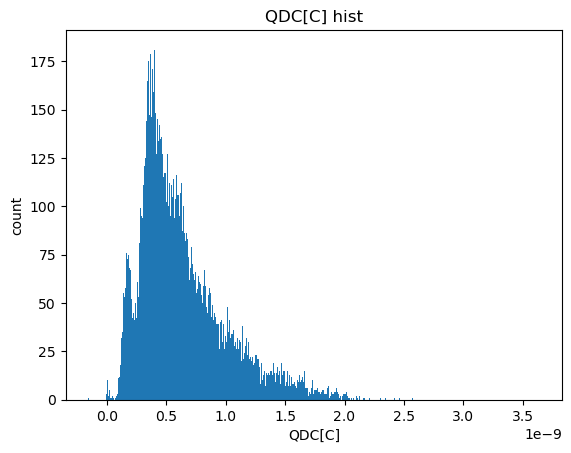

In [161]:
plt.hist(qdc,bins=1000)
plt.xlabel("QDC[C]")
plt.ylabel("count")
plt.title("QDC[C] hist")
#plt.xlim(0,100000)
print(np.max(qdc)-np.min(qdc))
#plt.hist(qdc,range=(np.max(qdc),np.min(qdc)),bins=int(np.max(qdc)-np.min(qdc)))

In [135]:
#filter1 peakが200-400nsの範囲内にあること
num=len(waveform)
fil1=[]
for i in range(num):
    peak_index=np.argmax(gfil_wave[i])
    if (peak_index < 200) or (peak_index > 400):
        fil1.append(0)
    else :
        fil1.append(1)


'\nfor i in range(num):\n    peak_index=np.argmax(gfil_wave[i])\n    #ma=np.convolve(gfil_wave[i][peak_index:],v,mode="same")\n    dif=np.diff(gfil_wave[i][peak_index:])\n    \n    #for n in range(len(ma)):\n\n'

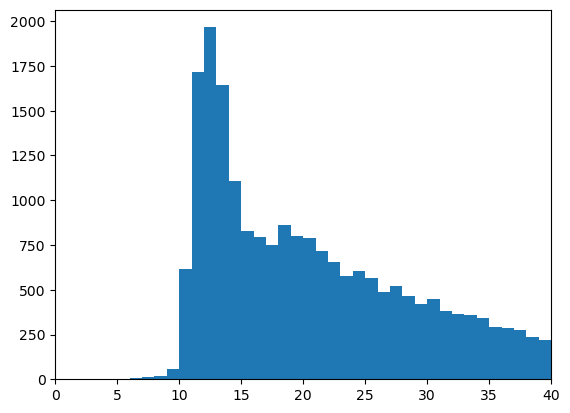

In [165]:
#filter2 difを計算して適切なthresholdで弾く
v = np.ones(5)/5.0
count=np.zeros(num)
dif=np.zeros((num,999))
for i in range(num):
    dif[i]=np.diff(gfil_wave[i])
    count[i]=np.count_nonzero(dif[i] > np.max(dif[i])*0.3)

plt.hist(count,range=(np.min(count),np.max(count)),bins=int(np.max(count)-np.min(count)))
plt.xlim(0,40)


In [207]:
afpl_flag=[]
n=0

for i in range(num):
    if count[i] < 18:
        afpl_flag.append(0)
        n=n+1
    else:
        afpl_flag.append(1)

print(n)





9517


In [208]:
qdc=np.zeros(len(waveform))

for i in range(num):
    if afpl_flag[i] == 0:
        peak_index=np.argmax(gfil_wave[i])
        qdc[i]=np.sum(gfil_wave[i][peak_index:peak_index+600])
    else:
        pass

    

(0.0, 35.0)

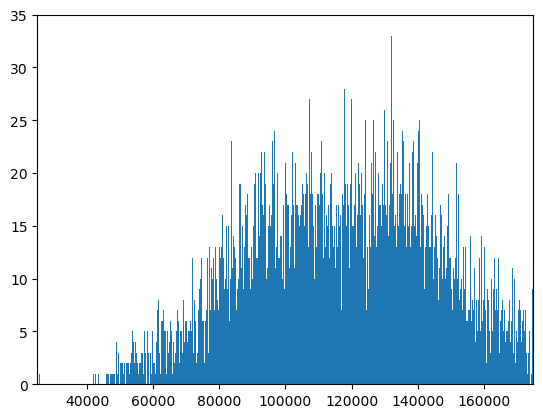

In [223]:
plt.hist(qdc,bins=1500)
plt.xlim(25000,175000)
plt.ylim(0,35)

#plt.yscale("log")

In [187]:
#ピーク中心を揃える
peak_index=[]
for i in range(num):


"""
for i in range(num):
    if afpl_flag[i] == 0:
        peak_index.append(np.argmax(gfil_wave[i]))
    else:
        pass
print(peak_index)
"""
#print(peak_index.index(min(peak_index)))



937


'\nfor i in range(num):\n    if afpl_flag[i] == 0:\n        peak_index.append(np.argmax(gfil_wave[i]))\n    else:\n        pass\nprint(peak_index)\n'

9517


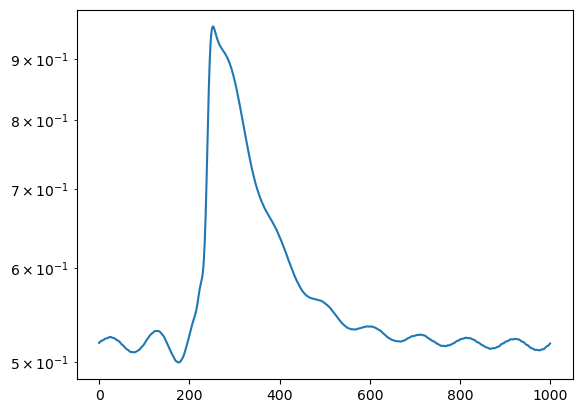

In [212]:
sumwave=np.zeros(wave_num)
n=0
for i in range(num):
    if afpl_flag[i] == 0:
        sumwave=sumwave+(gfil_wave[i]/np.max(gfil_wave[i]))
        n=n+1
    else:
        pass
avewave=sumwave/n
print(n)
plt.plot(time_array,avewave)


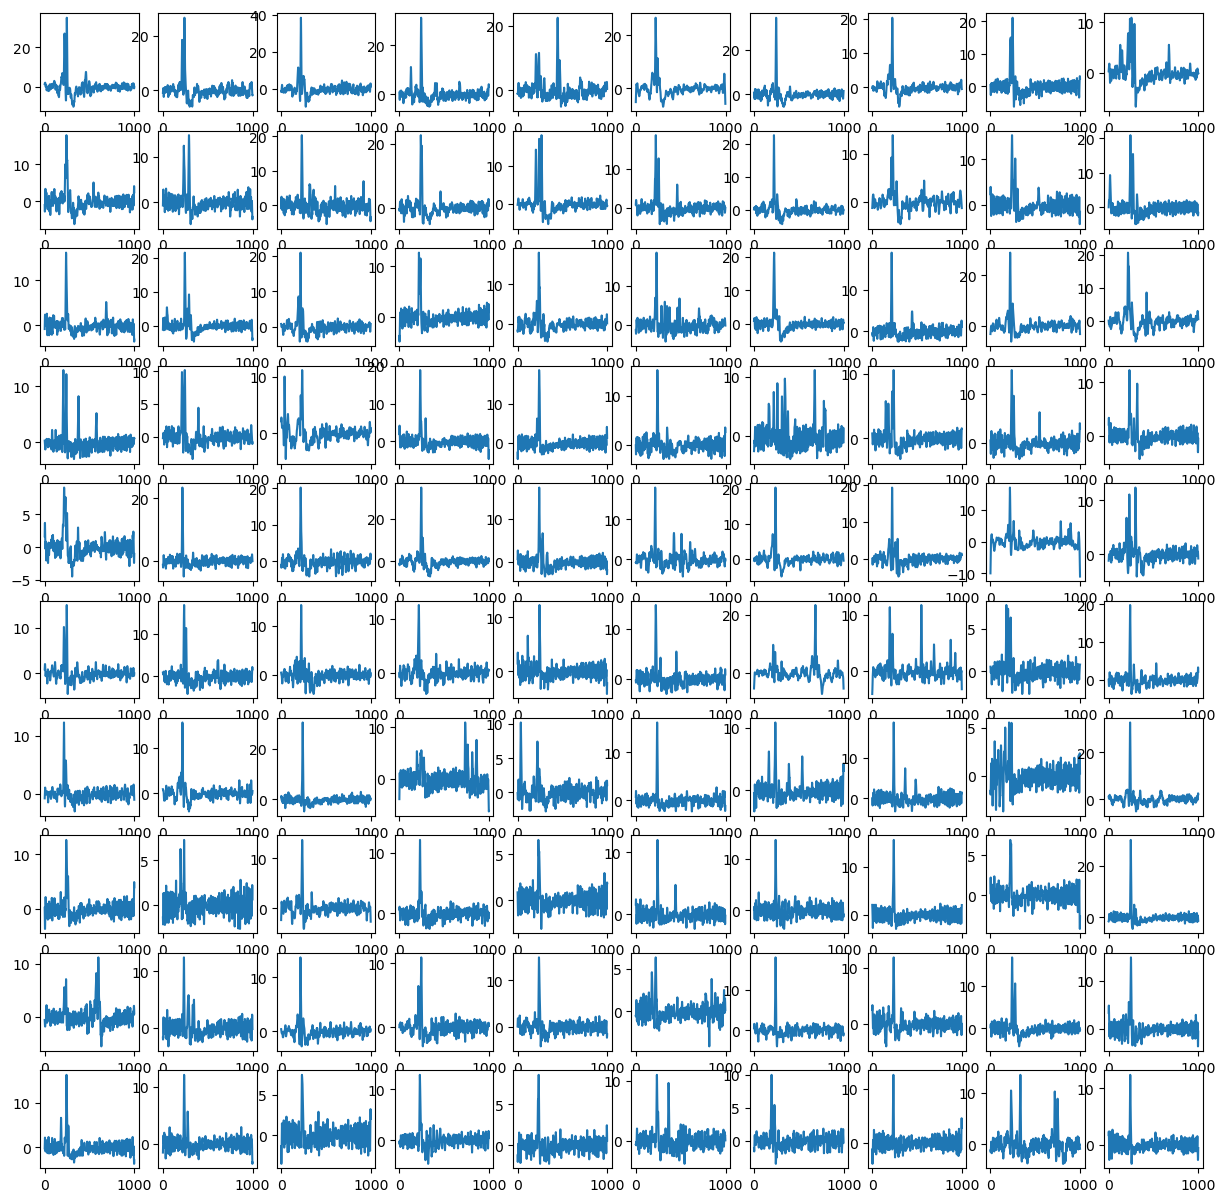

In [134]:
v = np.ones(5)/5.0
plt.figure(figsize=(15,15))
for i in range(100):
    peak_index=np.argmax(gfil_wave[i])
    #ma=np.convolve(gfil_wave[34][peak_index:],v,mode="same")
    dif=np.diff(gfil_wave[i])
    plt.subplot(10,10,i+1)
    plt.plot(time_array[:999],dif)

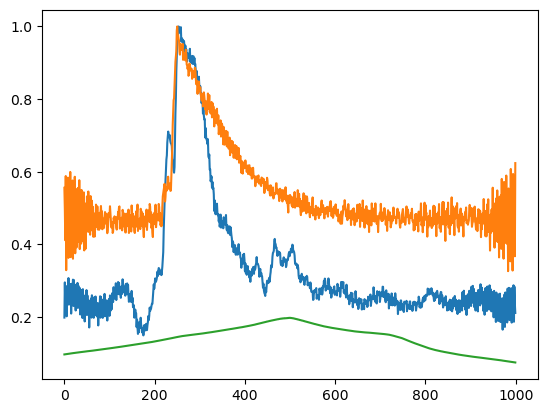

In [222]:
from scipy import signal as sg
sig_noise=fft_wave[0]
corr = sg.correlate(sig_noise/np.max(sig_noise), fft_wave[34]/np.max(fft_wave[34]), mode='same') / 1000
plt.plot(time_array,fft_wave[0]/np.max(fft_wave[0]))
plt.plot(time_array,fft_wave[34]/np.max(fft_wave[34]))
plt.plot(time_array,corr)

In [ ]:
plt.plot()